# CatBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, PrecisionRecallDisplay, plot_roc_curve
nltk.download('stopwords')
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 23 kB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read In Data

In [3]:
# READ IN DATA
model_data_raw = pd.read_csv('fj.csv', index_col = 0)


## Prepare Data For Model

In [4]:
model_data_catboost = model_data_raw.copy()

# Get number of unique countries
def getCountry(location):
    return str(location).split(',')[0]

model_data_catboost['country'] = model_data_catboost['location'].map(getCountry)

# droping unstructured columns
model_data_catboost.drop(['job_id','title','salary_range','description','requirements','benefits','company_profile','posting', 'location'], axis = 1, inplace = True)

# splitting data into train and test
X = model_data_catboost.drop('fraudulent', axis = 'columns')
y = model_data_catboost['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20,
                                                    random_state = 420)

# categorical features
cat_features = ['country', 'department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
cat_features_index = []
for cat_feature in cat_features:
    cat_features_index.append(X_train.columns.get_loc(cat_feature))

## Gridsearch for CatBoost

In [ ]:
# Source 1: https://catboost.ai/en/docs/concepts/python-usages-examples
# Source 2: https://www.analyticsvidhya.com/blog/2017/08/catboost-automated-categorical-data/
# Source 3: https://catboost.ai/en/docs/concepts/python-reference_catboost_grid_search#output-format

classifier = CatBoostClassifier(cat_features=cat_features_index)

grid = {'learning_rate': [0.01, 0.03, 0.1],
        'iterations': [30, 50, 90],
        'depth': [3, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'one_hot_max_size': [10, 50, 100, 150]}

grid_search_result = classifier.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

## Gridsearch Results

In [6]:
"""
{'depth': 10,
 'one_hot_max_size': 100,
 'l2_leaf_reg': 3,
 'iterations': 90,
 'learning_rate': 0.1}
"""
"""
best_depth = 10
best_OHMS = 100
best_12leaf = 3
best_iterations = 90
best_learning_rate = 0.1
"""
grid_search_result
best_depth = grid_search_result['params']['depth']
best_OHMS = grid_search_result['params']['one_hot_max_size']
best_12leaf = grid_search_result['params']['l2_leaf_reg']
best_iterations = grid_search_result['params']['iterations']
best_learning_rate = grid_search_result['params']['learning_rate']
grid_search_result['params']



## Run CatBoost Classifier
With the tuned parameters

In [7]:
# defining classifier
classifier = CatBoostClassifier(iterations=best_iterations, depth=best_depth, learning_rate=best_learning_rate, l2_leaf_reg=best_12leaf, cat_features=cat_features_index, one_hot_max_size=best_OHMS)

# Fit model
classifier.fit(X_train, y_train, silent=True)
# Get predicted classes
y_hat = classifier.predict(X_test)
# Get predicted probabilities for each class
y_pred_proba = classifier.predict_proba(X_test)
# Get predicted RawFormulaVal
preds_raw = classifier.predict(X_test, prediction_type='RawFormulaVal')

# Find errors
results_report = classification_report(y_test,y_hat)

# Confusion Matrix
print(confusion_matrix(y_test, y_hat))

# Accuracy Score
print("Accuracy Score: {}".format(accuracy_score(y_test, y_hat)))

# Precision Score
print("Precision Score: {}".format(precision_score(y_test, y_hat)))

# Recall Score
print("Recall Score: {}".format(recall_score(y_test, y_hat)))

# F1 Score
print("F1 Score: {}".format(f1_score(y_test, y_hat)))

print(results_report)

[[3399    4]
 [  58  115]]
Accuracy Score: 0.982662192393736
Precision Score: 0.9663865546218487
Recall Score: 0.6647398843930635
F1 Score: 0.7876712328767123
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.97      0.66      0.79       173

    accuracy                           0.98      3576
   macro avg       0.97      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576



## Plots

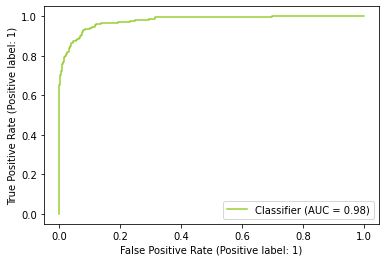

In [8]:
# ROC Curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred_proba[:, 1], color='yellowgreen')

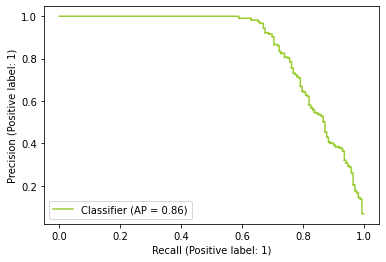

In [9]:
# Precision vs Recall Curve
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba[:, 1], color='yellowgreen')

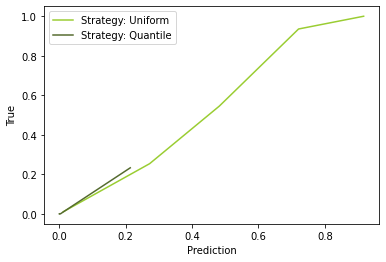

In [10]:
# Calibration Curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Strategy Uniform
prob_true1, prob_pred1 = calibration_curve(y_test, y_pred_proba[:,1], strategy = 'uniform')

# Strategy Quantile
prob_true2, prob_pred2 = calibration_curve(y_test, y_pred_proba[:,1], strategy = 'quantile')

plt.plot(prob_pred1, prob_true1, label='Strategy: Uniform', color='yellowgreen')
plt.plot(prob_pred2, prob_true2, label='Strategy: Quantile', color='darkolivegreen')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.legend(loc='best')
plt.show()